# Homework 2: Titanic Analysis
Data used: https://www.kaggle.com/competitions/titanic/data

<hr>

**DATA103 - S11** <br>
Group 2
 - Caballa, Allen
 - Chavez, Ruiz Lorenzo
 - Gammad, Alyanna
 - Mejia, Jo-anne
 - Panugan, Ria Juvica

## Importing Libraries and Dataset

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno
from sklearn.impute import KNNImputer

In [28]:
train_df = pd.read_csv("data/train.csv", index_col="PassengerId")
train_shape = train_df.shape
display(train_df.head())
print(f"Entries: {train_shape[0]}\nFeatures: {train_shape[1]}")

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Entries: 891
Features: 11


## Exploratory Data Analysis

In [29]:
# initial dtypes of each column
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


<AxesSubplot:>

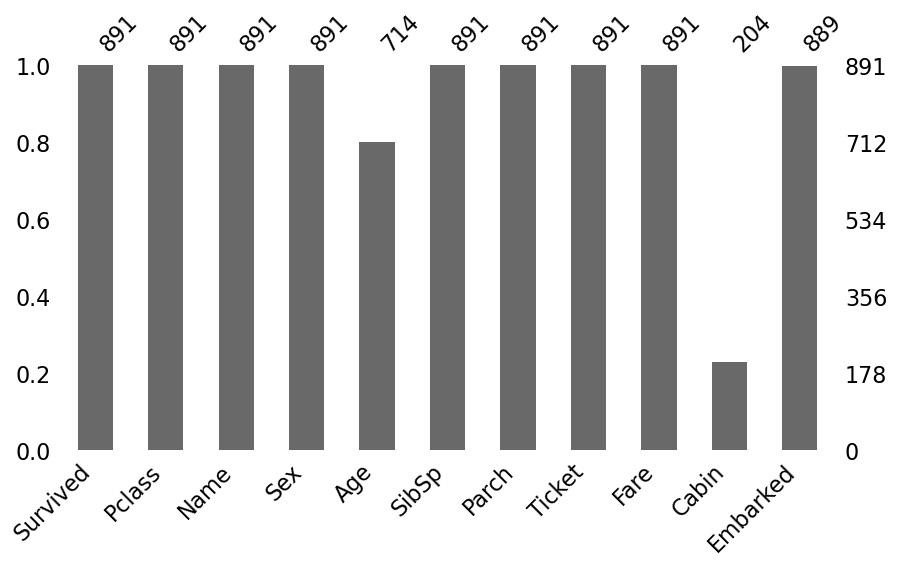

In [30]:
#  null entries
msno.bar(train_df, figsize=(10,5))

In [31]:
#  number of unique values
train_df.nunique()

Survived      2
Pclass        3
Name        891
Sex           2
Age          88
SibSp         7
Parch         7
Ticket      681
Fare        248
Cabin       147
Embarked      3
dtype: int64

In [32]:
train_df.query("Ticket == 'CA. 2343'")

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [33]:
train_df.sort_values("SibSp")

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
446,1,1,"Dodge, Master. Washington",male,4.0,0,2,33638,81.8583,A34,S
535,0,3,"Cacic, Miss. Marija",female,30.0,0,0,315084,8.6625,NaN,S
536,1,2,"Hart, Miss. Eva Miriam",female,7.0,0,2,F.C.C. 13529,26.2500,NaN,S
537,0,1,"Butt, Major. Archibald Willingham",male,45.0,0,0,113050,26.5500,B38,S
538,1,1,"LeRoy, Miss. Bertha",female,30.0,0,0,PC 17761,106.4250,NaN,C
...,...,...,...,...,...,...,...,...,...,...,...
181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.5500,NaN,S
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.5500,NaN,S


In [34]:
#  check if there are duplicated passengers
count_duplicated_passengers = train_df.Name.duplicated().sum()
print(f"There are {count_duplicated_passengers} duplicated passengers in this log.")

There are 0 duplicated passengers in this log.


What needs to be done:
1. reformat column names -> lowercase 
2. deal with entries/features with null values: impute or drop

In [35]:
#  reformat column names
train_df.columns = train_df.columns.str.lower()
train_df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [36]:
#  check entries with null Age values
null_age = train_df.age.isna()
display(train_df[null_age].head())
print(f"There are {null_age.sum()} passengers with no age specified.")
print(f"That is {(null_age.sum() / train_df.shape[0]) * 100:.2f}% of the entire train_df with no specified age")

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q


There are 177 passengers with no age specified.
That is 19.87% of the entire train_df with no specified age


In [37]:
# #  impute values with average or drop entries with no ages?
# def age_solution(df):
#     return

# train_df = age_solution(train_df)

In [38]:
#  check entries with null Cabin values
null_cabin = train_df.cabin.isna()
display(train_df[null_cabin].head())
print(f"There are {null_cabin.sum()} passengers with no cabin specified.")
print(f"That is {(null_cabin.sum() / train_df.shape[0]) * 100:.2f}% of the entire train_df with no specified cabin ID")

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


There are 687 passengers with no cabin specified.
That is 77.10% of the entire train_df with no specified cabin ID


In [39]:
#  drop cabin column
def cabin_solution(df):
    return df.drop(columns=["cabin"])

train_df = cabin_solution(train_df)
train_df

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S


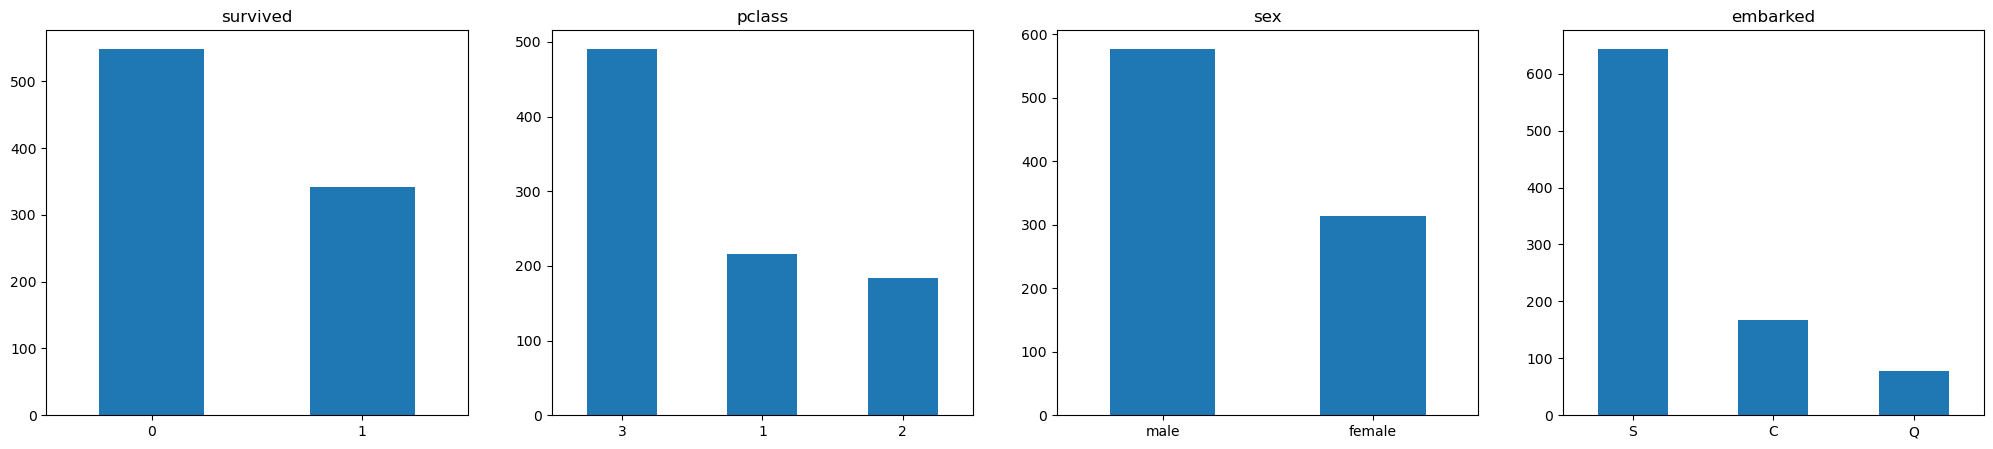

In [40]:
fig, axs = plt.subplots(1,4, figsize=(25,5))

bar_list = ["survived", 
            "pclass",
            "sex",
            "embarked",]

for i, col in enumerate(bar_list):
    train_df[col].value_counts().plot(kind="bar",
                       ax=axs[i],
                       rot=0)
    axs[i].set_title(col)

The plots above illustrate the dominating demographics of Titanic passengers. Here are observations:
- More people died than survived.
- Passengers are dominantly 3rd class
- There were more males onboard
- Most passengers embarked in Southampton

Survival rate of 1: 62.96%
Survival rate of 2: 47.28%
Survival rate of 3: 24.24%
Survival rate of female: 74.20%
Survival rate of male: 18.89%
Survival rate of C: 55.36%
Survival rate of Q: 38.96%
Survival rate of S: 33.70%


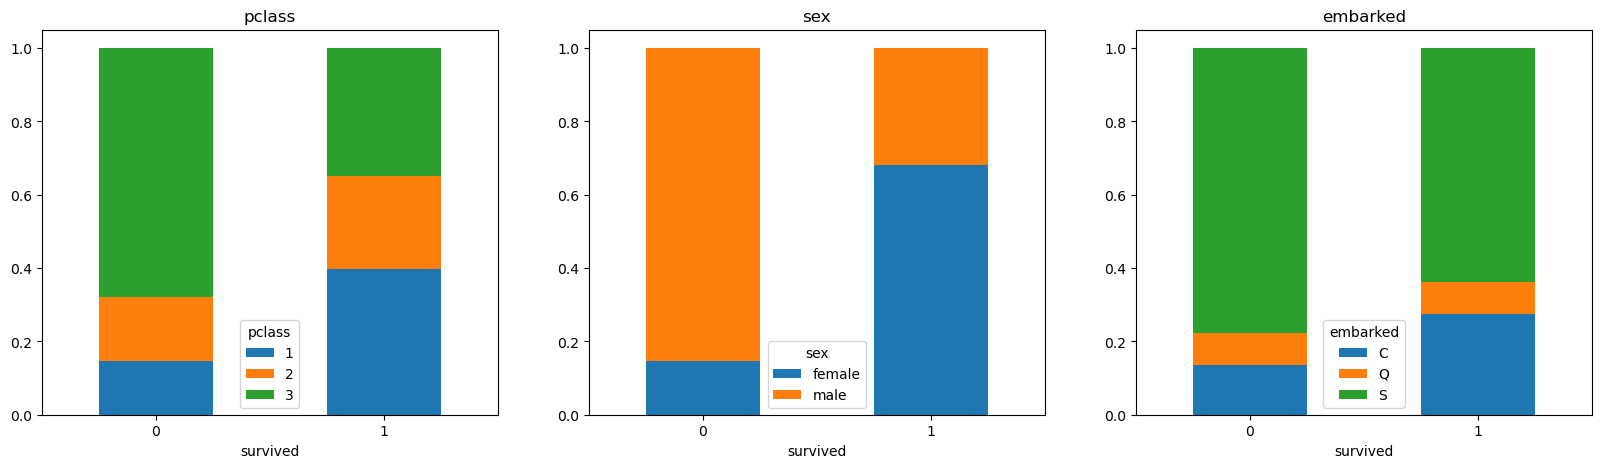

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))

col_list = ["pclass",
            "sex",
            "embarked",]

for i, col in enumerate(col_list):
    pd.crosstab(train_df["survived"], train_df[col], normalize="index").plot.bar(stacked=True, ax=axs[i], rot=0)
    axs[i].set_title(col)
    
for col in col_list:
    survival_rates = pd.crosstab(train_df["survived"], train_df[col], normalize="columns").loc[1]
    for category in survival_rates.index:
        print(f"Survival rate of {category}: {survival_rates[category] * 100:.2f}%")
    

The plots above show the survivability categorized by `pclass`, `sex`, and `embarked`. Here are some independent observations on the *normalized* data:

- A passenger was more likely to perish if he/she is in a lower pasengger class. 
- More females survived
- Those who embarked in Southampton has higher survival rates (based on normalized data).

Mean Age: 29.70
Median Age: 28.0

Mean Fare: 32.20
Median Fare: 14.45


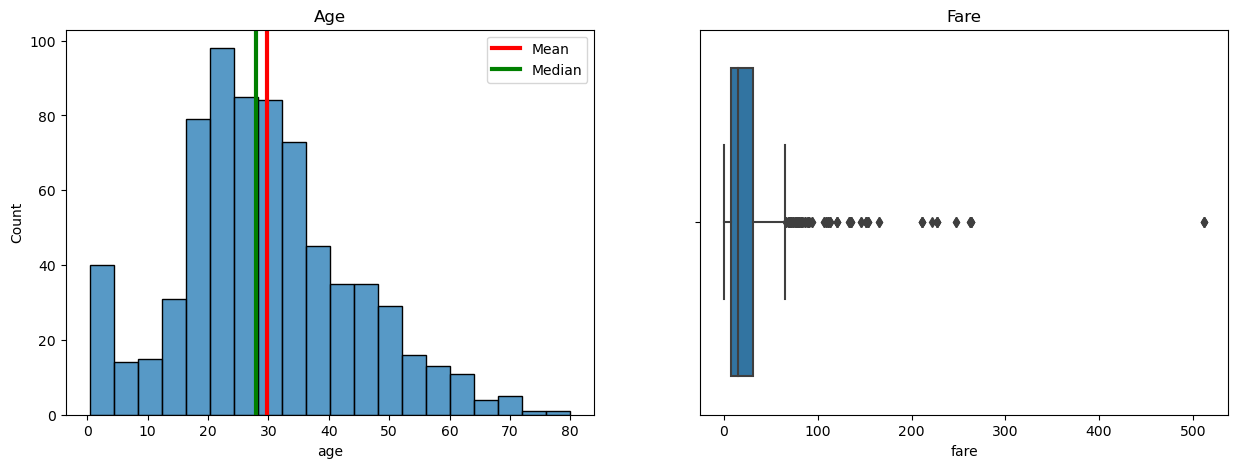

In [43]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

sns.histplot(data=train_df,
             x="age",
             ax=axs[0])
axs[0].set_title("Age")
axs[0].axvline(x=train_df.age.mean(),
               linewidth=3, 
               color='r',
               label="Mean"
               )
axs[0].axvline(x=train_df.age.median(),
               linewidth=3, 
               color='g',
               label="Median"
               )
axs[0].legend()

sns.boxplot(data=train_df,
            x="fare",
            ax=axs[1])
axs[1].set_title("Fare")

print(f"Mean Age: {train_df.age.mean():.2f}")
print(f"Median Age: {train_df.age.median()}\n")
print(f"Mean Fare: {train_df.fare.mean():.2f}")
print(f"Median Fare: {train_df.fare.median():.2f}")

mean               min          max      
sex          female       male female  male female  male
survived                                                
0         25.046875  31.618056   2.00  1.00   57.0  74.0
1         28.847716  27.276022   0.75  0.42   63.0  80.0

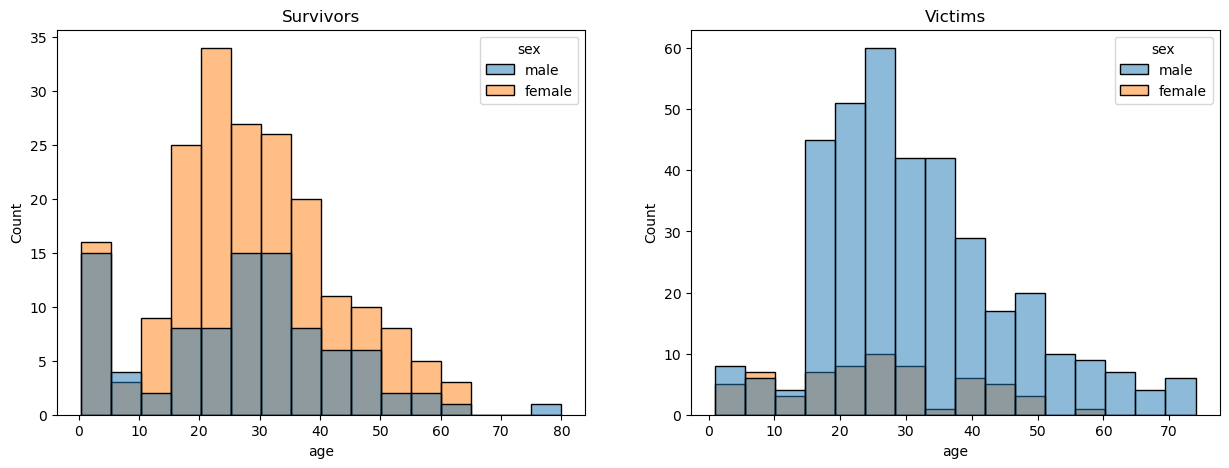

In [18]:
survivors = train_df.query("survived == 1")
victims = train_df.query("survived == 0")

fig, axs = plt.subplots(1,2, figsize=(15,5))

sns.histplot(data=survivors,
             x="age",
             hue="sex",
             ax=axs[0],
             hue_order=["male", "female"]
             )
axs[0].set_title("Survivors")

sns.histplot(data=victims,
             x="age",
             hue="sex",
             ax=axs[1],
             hue_order=["male", "female"]
             )
axs[1].set_title("Victims")

sex_numerical = pd.crosstab(train_df.survived, train_df.sex, train_df.age, aggfunc=[np.mean, min, max])
display(sex_numerical)

Observations:
- Across all ages, more females survived than males.
- Most passengers are middle aged

mean                         min                max            
pclass            1          2          3     1      2     3     1     2     3
survived                                                                      
0         43.695312  33.544444  26.555556  2.00  16.00  1.00  71.0  70.0  74.0
1         35.368197  25.901566  20.646118  0.92   0.67  0.42  80.0  62.0  63.0

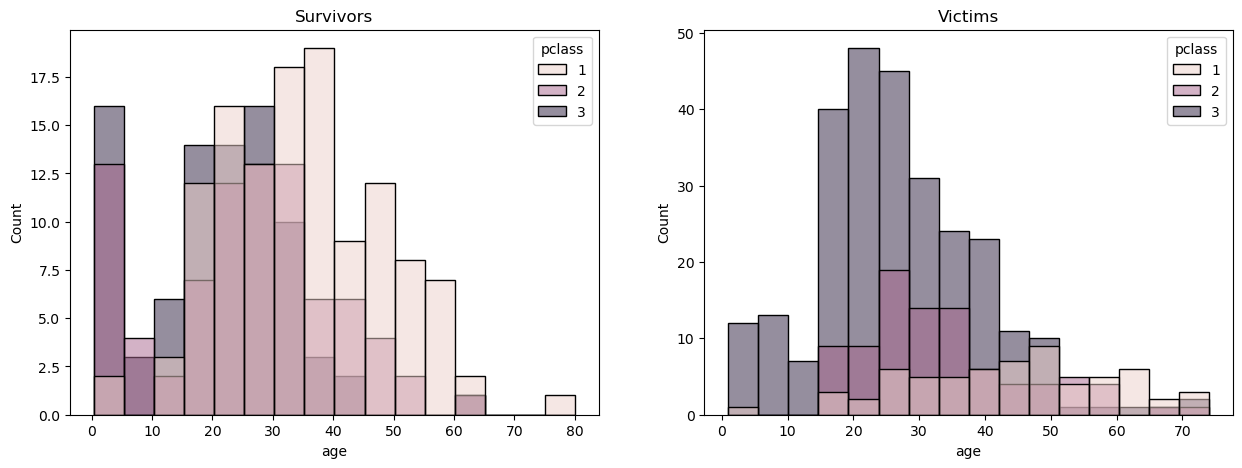

In [19]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

sns.histplot(data=survivors,
             x="age",
             hue="pclass",
             ax=axs[0],
             hue_order=["male", "female"]
             )
axs[0].set_title("Survivors")

sns.histplot(data=victims,
             x="age",
             hue="pclass",
             ax=axs[1],
             hue_order=["male", "female"]
             )
axs[1].set_title("Victims")

pclass_numerical = pd.crosstab(train_df.survived, train_df.pclass, train_df.age, aggfunc=[np.mean, min, max])
display(pclass_numerical)

Observations:
- 2nd and 1st class passengers were more likely to survive
- Most that perished were 3rd class passengers

In [20]:
#  one hot encoding for sex and embarked features
train_df = pd.get_dummies(data=train_df,
                          columns=["sex", "embarked"])
train_df

,survived,pclass,name,age,sibsp,parch,ticket,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,0,1,0,0,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,1,0,1,0,0
3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,1,0,0,0,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,1,0,0,0,1
5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,0,1,0,0,1
888,1,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,1,0,0,0,1
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",NaN,1,2,W./C. 6607,23.4500,1,0,0,0,1


In [21]:
#  companion count column
train_df["companions"] = train_df.sibsp + train_df.parch
train_df = train_df.drop(columns=["sibsp", "parch"])
train_df.sort_values("companions")

,survived,pclass,name,age,ticket,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,companions
PassengerId,,,,,,,,,,,,
891,0,3,"Dooley, Mr. Patrick",32.0,370376,7.7500,0,1,0,1,0,0
681,0,3,"Peters, Miss. Katie",NaN,330935,8.1375,1,0,0,1,0,0
682,1,1,"Hassab, Mr. Hammad",27.0,PC 17572,76.7292,0,1,1,0,0,0
392,1,3,"Jansson, Mr. Carl Olof",21.0,350034,7.7958,0,1,0,0,1,0
683,0,3,"Olsvigen, Mr. Thor Anderson",20.0,6563,9.2250,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
202,0,3,"Sage, Mr. Frederick",NaN,CA. 2343,69.5500,0,1,0,0,1,10
160,0,3,"Sage, Master. Thomas Henry",NaN,CA. 2343,69.5500,0,1,0,0,1,10
793,0,3,"Sage, Miss. Stella Anna",NaN,CA. 2343,69.5500,1,0,0,0,1,10


Survival rate for passengers with 0 companions: 30.35%
Survival rate for passengers with 1 companions: 55.28%
Survival rate for passengers with 2 companions: 57.84%
Survival rate for passengers with 3 companions: 72.41%
Survival rate for passengers with 4 companions: 20.00%
Survival rate for passengers with 5 companions: 13.64%
Survival rate for passengers with 6 companions: 33.33%
Survival rate for passengers with 7 companions: 0.00%
Survival rate for passengers with 10 companions: 0.00%


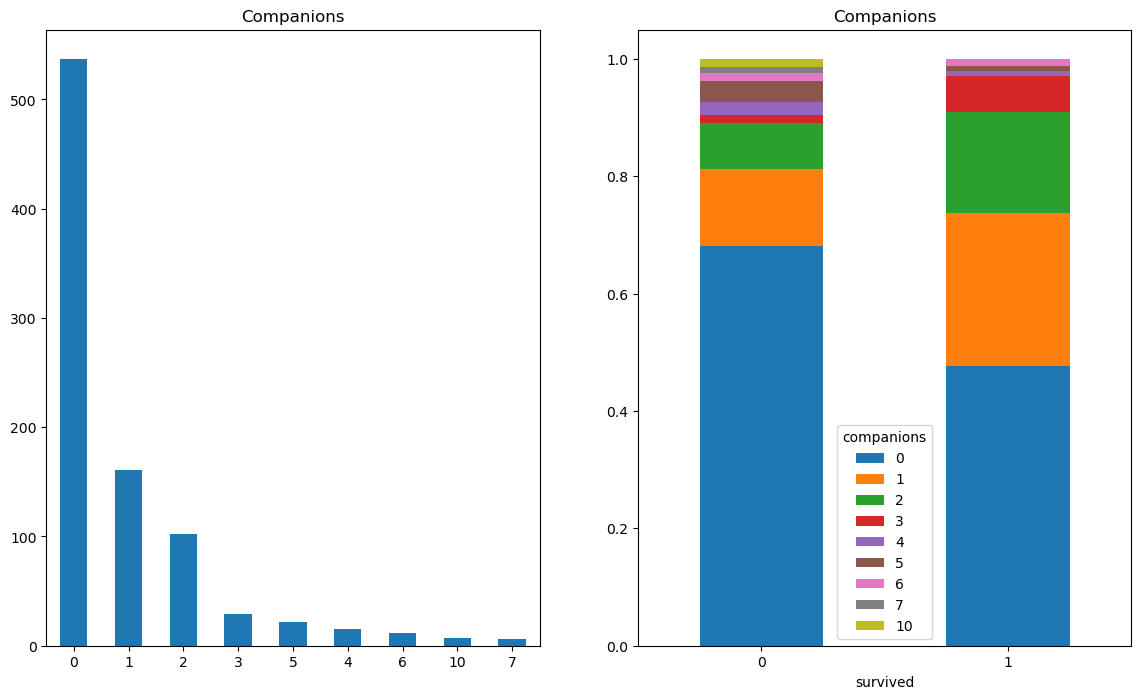

In [22]:
fig, axs = plt.subplots(1,2, figsize=(14,8))

train_df.companions.value_counts().plot.bar(ax=axs[0], rot=0,title="Companions")
pd.crosstab(train_df.survived, train_df.companions, normalize="index").plot.bar(stacked=True, ax=axs[1],rot=0,title="Companions")

survivor_companions = pd.crosstab(train_df.survived, train_df.companions, normalize="columns").loc[1] * 100

for idx in survivor_companions.index:
    print(f"Survival rate for passengers with {idx} companions: {survivor_companions[idx]:.2f}%")

Observations based on data:
- you are likely to survive by having 1-3 companions

Observations based on *normalized* data:
- you are more likely to survive with less companions

In [23]:
train_df.companions.value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: companions, dtype: int64

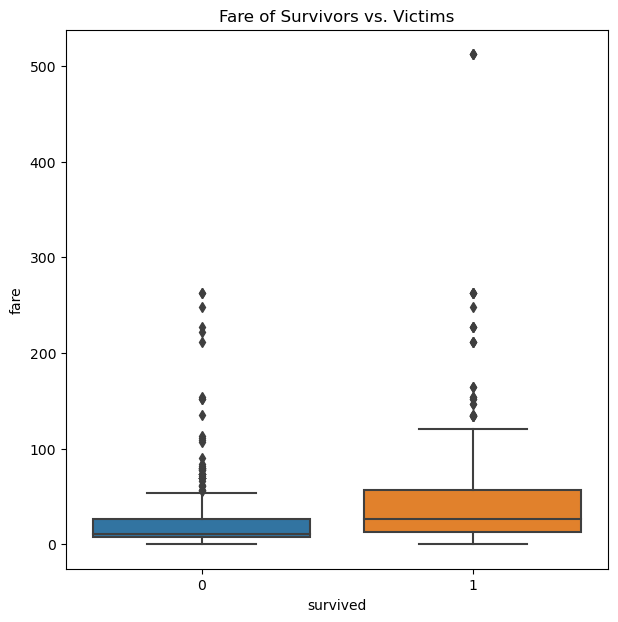

Survivors Mean Fare: 48.40
Survivors Median Fare: 26.00
Victims Mean Fare: 22.12
Victims Median Fare: 10.50


In [48]:
fig, axs = plt.subplots(1,1, figsize=(7,7))

sns.boxplot(data=train_df,
            x="survived", y="fare")
axs.set_title("Fare of Survivors vs. Victims")
plt.show()

print(f"Survivors Mean Fare: {train_df.query('survived==1')['fare'].mean():.2f}")
print(f"Survivors Median Fare: {train_df.query('survived==1')['fare'].median():.2f}")
print(f"Victims Mean Fare: {train_df.query('survived==0')['fare'].mean():.2f}")
print(f"Victims Median Fare: {train_df.query('survived==0')['fare'].median():.2f}")

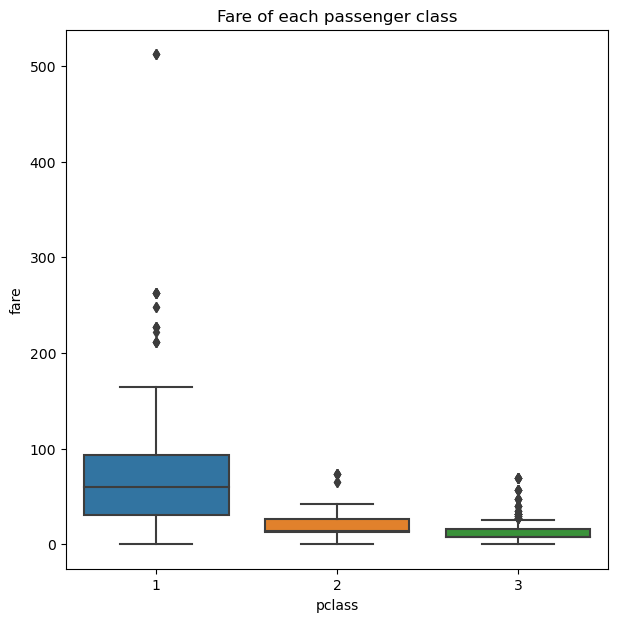

pclass 1 Mean & Median Fare: 84.15 | 60.29
pclass 2 Mean & Median Fare: 20.66 | 14.25
pclass 3 Mean & Median Fare: 13.68 | 8.05


In [49]:
fig, axs = plt.subplots(1,1, figsize=(7,7))

sns.boxplot(data=train_df,
            x="pclass", y="fare")
axs.set_title("Fare of each passenger class")
plt.show()

print(f"pclass 1 Mean & Median Fare: {train_df.query('pclass==1')['fare'].mean():.2f} | {train_df.query('pclass==1')['fare'].median():.2f}")
print(f"pclass 2 Mean & Median Fare: {train_df.query('pclass==2')['fare'].mean():.2f} | {train_df.query('pclass==2')['fare'].median():.2f}")
print(f"pclass 3 Mean & Median Fare: {train_df.query('pclass==3')['fare'].mean():.2f} | {train_df.query('pclass==3')['fare'].median():.2f}")